In [28]:
from processing_utils import DataPrepare
from studu_utils import load_best_global, save_best_global, plot_feature_importance

import polars as pl
import pandas as pd
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt
import optuna



In [2]:
df: pl.DataFrame = pl.read_parquet(r'C:\Users\310\Desktop\Progects_Py\data\microstructure_price_prediction_data\dfs\2024-06-29 20-00-00_2024-07-01 00-00-00_delta_0-00-10_return_5_sec.parquet')
target_var: str = "log_return"
cols_to_exclude: list[str] = []
# File to store the best global results
BEST_GLOBAL_FILE = "best_global_RF.json"

In [3]:
data = DataPrepare(df)

In [4]:
data.normalize(cross_section_id="cross_section_id", exclude_columns=["currency_pair", target_var])

currency_pair,cross_section_id,log_interval_return,num_aggregated_trades,volume_imbalance_FIVE_SECONDS,volume_imbalance_TEN_SECONDS,volume_imbalance_HALF_MINUTE,volume_imbalance_MINUTE,slippage_imbalance_FIVE_SECONDS,slippage_imbalance_TEN_SECONDS,slippage_imbalance_HALF_MINUTE,slippage_imbalance_MINUTE,log_return
str,datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""DOGEUSDT""",2024-06-29 20:00:10,-0.707107,0.707107,0.707107,-0.707107,-0.707107,-0.707107,NaN,0.707107,0.707107,0.707107,0.000081
"""AVAXUSDT""",2024-06-29 20:00:10,0.707107,-0.707107,-0.707107,0.707107,0.707107,0.707107,NaN,-0.707107,-0.707107,-0.707107,0.000358
"""DOGEUSDT""",2024-06-29 20:00:20,-0.707107,0.707107,NaN,0.707107,0.707107,0.707107,NaN,NaN,NaN,NaN,-0.000081
"""AVAXUSDT""",2024-06-29 20:00:20,0.707107,-0.707107,NaN,-0.707107,-0.707107,-0.707107,NaN,NaN,NaN,NaN,0.000358
"""DOGEUSDT""",2024-06-29 20:00:30,0.707107,-0.707107,NaN,-0.707107,-0.707107,-0.707107,NaN,-0.707107,-0.707107,-0.707107,-0.000081
…,…,…,…,…,…,…,…,…,…,…,…,…
"""AVAXUSDT""",2024-06-30 23:59:40,0.707107,-0.707107,NaN,-0.707107,-0.707107,-0.707107,NaN,0.0,0.0,0.0,0.00034
"""DOGEUSDT""",2024-06-30 23:59:50,0.707107,-0.707107,NaN,-0.707107,-0.707107,-0.707107,NaN,NaN,NaN,NaN,0.0
"""AVAXUSDT""",2024-06-30 23:59:50,-0.707107,0.707107,NaN,0.707107,0.707107,0.707107,NaN,NaN,NaN,NaN,null


In [18]:
data.train_test_split(train_test_ratio=0.7, exclude_columns="cross_section_id")
X_train, y_train, X_test, y_test, = data.X_y_split(target_var=target_var, target_encode=True)

Train test ratio is 0.7
Train len for AVAXUSDT is 5763
Test len for AVAXUSDT is 2470
Train len for DOGEUSDT is 6664
Test len for DOGEUSDT is 2856


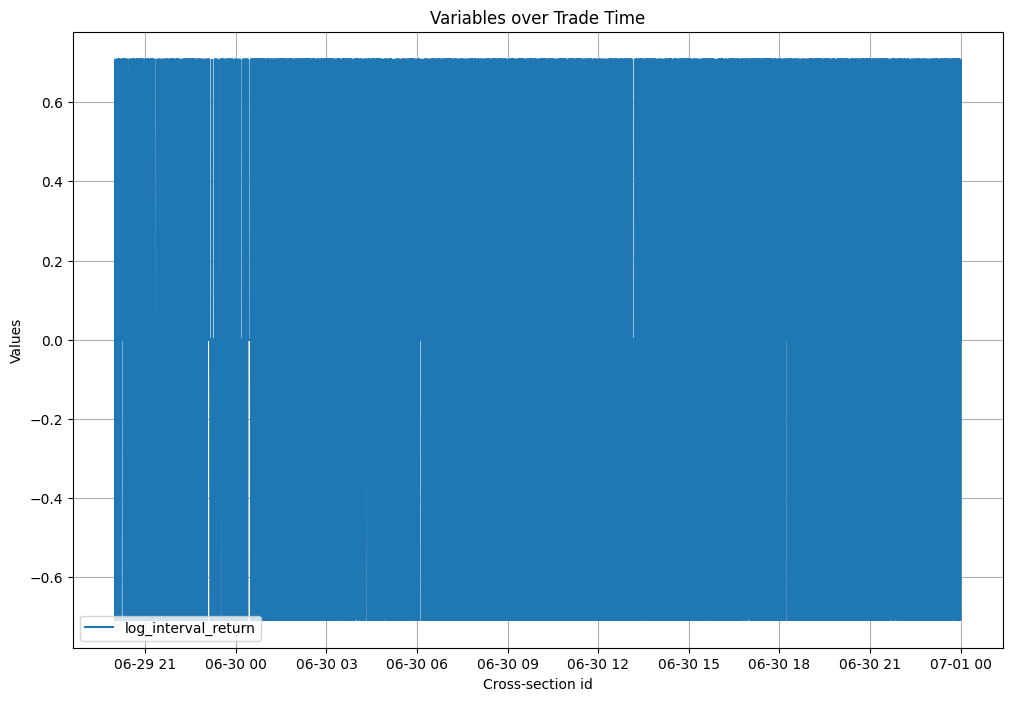

In [6]:
data.visualize(datetime(2024, 6, 20), datetime(2024, 7, 1), variables_to_plot=["log_interval_return"])

In [7]:
# Initialize best global results
best_global = load_best_global(BEST_GLOBAL_FILE)

In [8]:
def objective(trial, X_train, y_train, features):
    # Store the features in trial user attributes
    trial.set_user_attr("features", features)

    # Hyperparameter space
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    max_depth = trial.suggest_int("max_depth", 3, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_weight_fraction_leaf = trial.suggest_float("min_weight_fraction_leaf", 0.0, 0.5)
    min_impurity_decrease = trial.suggest_float("min_impurity_decrease", 0.0, 0.5)

    # Define the RandomForestRegressor with trial parameters
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_weight_fraction_leaf=min_weight_fraction_leaf,
        min_impurity_decrease=min_impurity_decrease,
        random_state=42,
        n_jobs=-1,
    )

    # Use K-Fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mse_scores = -cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=kf)

    return np.mean(mse_scores)


In [9]:
def optimize_with_dataset(X_train, y_train, study_name=None):
    global best_global

    features = list(X_train.columns)

    if study_name:
        pass
    if features == best_global["features"]:
        study_name = best_global["study_name"]
    else:
        study_name = datetime.now().strftime("study_%Y-%m-%d_%H-%M-%S")
    

    # Create a new study
    study = optuna.create_study(
        study_name=study_name,
        storage="sqlite:///optuna_study_RF.db",
        direction="minimize",
        load_if_exists=True
    )

    # Run optimization
    study.optimize(lambda trial: objective(trial, X_train, y_train, features), n_trials=10)

    # Update the global best result if the current study has a better score
    if study.best_value < best_global["best_value"]:
        best_global.update(
            {
                "study_name": study_name,
                "best_value": study.best_value,
                "best_params": study.best_params,
                "features": features,
            }
        )
        # Save the updated best global results to disk
        save_best_global(best_global, BEST_GLOBAL_FILE)

    print(f"Study: {study_name}")
    print(f"Best Value: {study.best_value}")
    print(f"Best Params: {study.best_params}")

    return study


In [19]:
X_train

log_interval_return,num_aggregated_trades,volume_imbalance_FIVE_SECONDS,volume_imbalance_TEN_SECONDS,volume_imbalance_HALF_MINUTE,volume_imbalance_MINUTE,slippage_imbalance_FIVE_SECONDS,slippage_imbalance_TEN_SECONDS,slippage_imbalance_HALF_MINUTE,slippage_imbalance_MINUTE,currency_pair_mean
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.707107,-0.707107,-0.707107,0.707107,0.707107,0.707107,NaN,-0.707107,-0.707107,-0.707107,0.000014
0.707107,-0.707107,NaN,-0.707107,-0.707107,-0.707107,NaN,NaN,NaN,NaN,0.000014
-0.707107,0.707107,NaN,0.707107,0.707107,0.707107,NaN,0.707107,0.707107,0.707107,0.000014
-0.707107,-0.707107,-0.707107,-0.707107,-0.707107,-0.707107,0.0,0.0,0.0,0.0,0.000014
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000014
…,…,…,…,…,…,…,…,…,…,…
0.0,0.707107,NaN,-0.707107,-0.707107,-0.707107,NaN,NaN,NaN,NaN,5.4045e-7
0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,5.4045e-7
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.4045e-7


In [20]:
study = optimize_with_dataset(X_train, y_train)

[I 2024-12-18 20:08:47,617] A new study created in RDB with name: study_2024-12-18_20-08-47
[I 2024-12-18 20:08:51,055] Trial 0 finished with value: 2.7138684148235915e-08 and parameters: {'n_estimators': 284, 'max_depth': 38, 'min_samples_split': 18, 'min_weight_fraction_leaf': 0.09185470427876069, 'min_impurity_decrease': 0.4141186403483449}. Best is trial 0 with value: 2.7138684148235915e-08.
[I 2024-12-18 20:08:52,231] Trial 1 finished with value: 2.7139307058316257e-08 and parameters: {'n_estimators': 68, 'max_depth': 27, 'min_samples_split': 12, 'min_weight_fraction_leaf': 0.118858100696762, 'min_impurity_decrease': 0.4044929555560298}. Best is trial 0 with value: 2.7138684148235915e-08.
[I 2024-12-18 20:08:56,930] Trial 2 finished with value: 2.7138754999722597e-08 and parameters: {'n_estimators': 392, 'max_depth': 11, 'min_samples_split': 9, 'min_weight_fraction_leaf': 0.20638559562350817, 'min_impurity_decrease': 0.06429396200594523}. Best is trial 0 with value: 2.713868414823

Study: study_2024-12-18_20-08-47
Best Value: 2.713858561254507e-08
Best Params: {'n_estimators': 302, 'max_depth': 43, 'min_samples_split': 11, 'min_weight_fraction_leaf': 0.3964429373075319, 'min_impurity_decrease': 0.10884548898439173}


In [16]:
# To open dashbourd run this:
!optuna-dashboard sqlite:///optuna_study_RF.db

# And listen to:
# http://localhost:8080/


^C


In [21]:
# Test
rf_model = RandomForestRegressor(**study.best_params, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"MSE on test: {mse:.4f} \nMAPE on test: {mape:.4f}")


MSE on test: 0.0000 
MAPE on test: 12083507695.2075


In [41]:
def permutation_feature_importance(model, X_test, y_test, metrics):
    """
    Evaluates feature importance by shuffling one feature at a time and measuring the impact on model performance.
    
    Parameters:
    - model: Trained model to evaluate.
    - X_test (pl.DataFrame): Test features.
    - y_test (pl.Series): True labels.
    - metrics (list[function]): List of metric functions to evaluate model performance.

    Returns:
    - results (dict): A dictionary where keys are metric names, and values are DataFrames
                      containing features and their corresponding performance scores.
    """
    if isinstance(X_test, pl.DataFrame):
        X_test = pd.DataFrame(X_test, columns=X_test.columns)
        y_test = pd.Series(y_test)
    
    results = {}

    # Iterate over metrics
    for metric in metrics:
        metric_name = metric.__name__
        metric_results = []

        baseline_score = metric(y_test, model.predict(X_test))

        # Iterate over each feature in X_test
        for feature in X_test.columns:
            X_test_shuffled = X_test.copy()

            X_test_shuffled[feature] = np.random.permutation(X_test_shuffled[feature])
            shuffled_score = metric(y_test, model.predict(X_test_shuffled))

            metric_results.append({
                "feature": feature,
                "baseline_score": baseline_score,
                "shuffled_score": shuffled_score,
                "score_difference": baseline_score - shuffled_score
            })

        results[metric_name] = pl.DataFrame(metric_results)

    return results

In [47]:
def plot_feature_premutation_importance(results):
    """
    Plots feature importance based on score differences for each metric.

    Parameters:
    - results (dict): A dictionary where keys are metric names, and values are Polars DataFrames
                      containing features and their corresponding performance scores.
    """
    for metric_name, df in results.items():
        df_sorted = df.sort("score_difference", descending=True)

        # Plot the feature importances
        plt.figure(figsize=(10, 6))
        plt.barh(df_sorted["feature"], df_sorted["score_difference"], color="skyblue")
        plt.xlabel("Score Difference")
        plt.ylabel("Feature")
        plt.title(f"Feature Importance ({metric_name})")
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
        

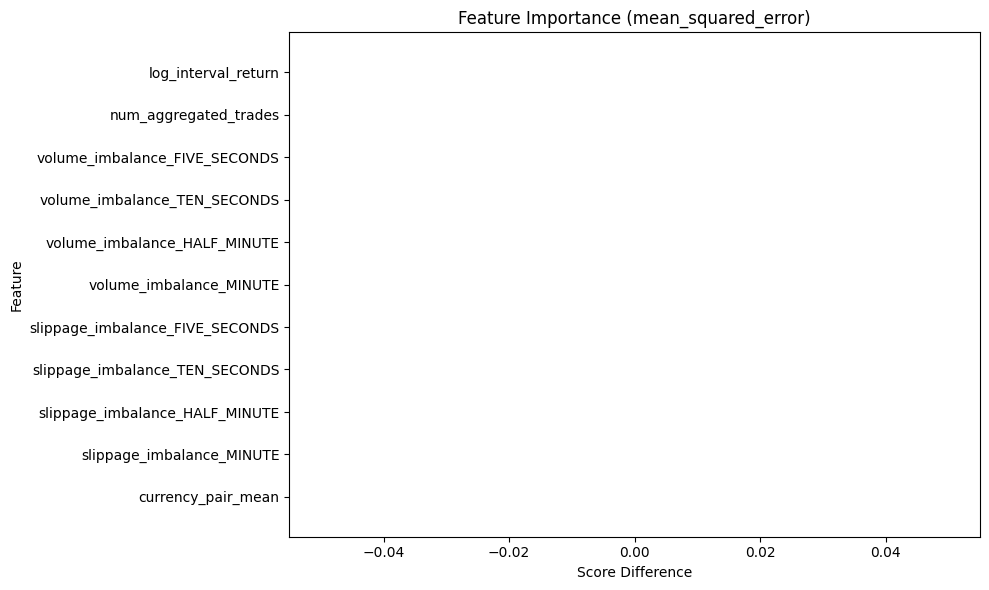

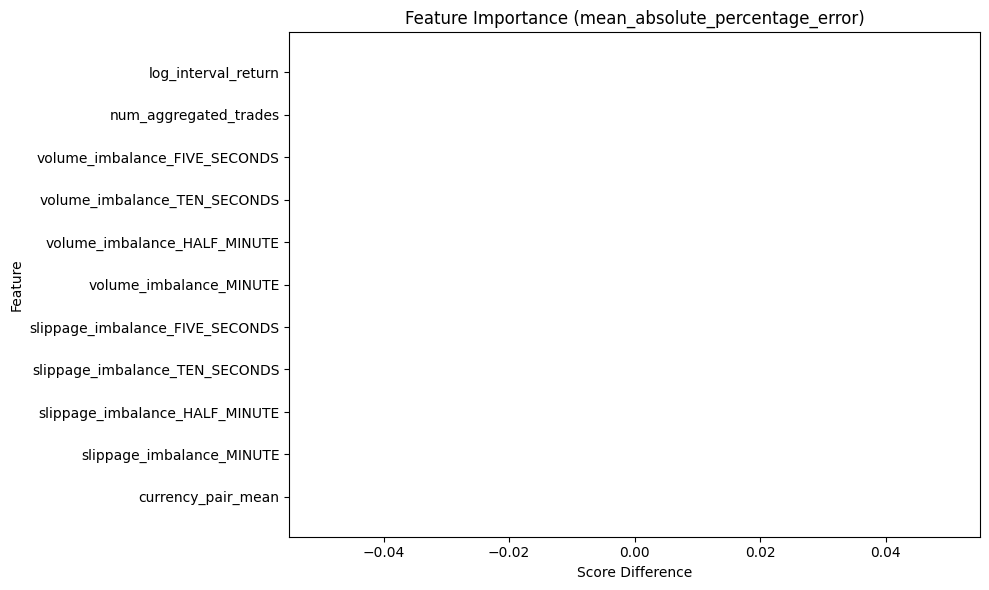

In [48]:
results = permutation_feature_importance(model=rf_model, X_test=X_test, y_test=y_test, metrics=[mean_squared_error, mean_absolute_percentage_error])
plot_feature_premutation_importance(results)

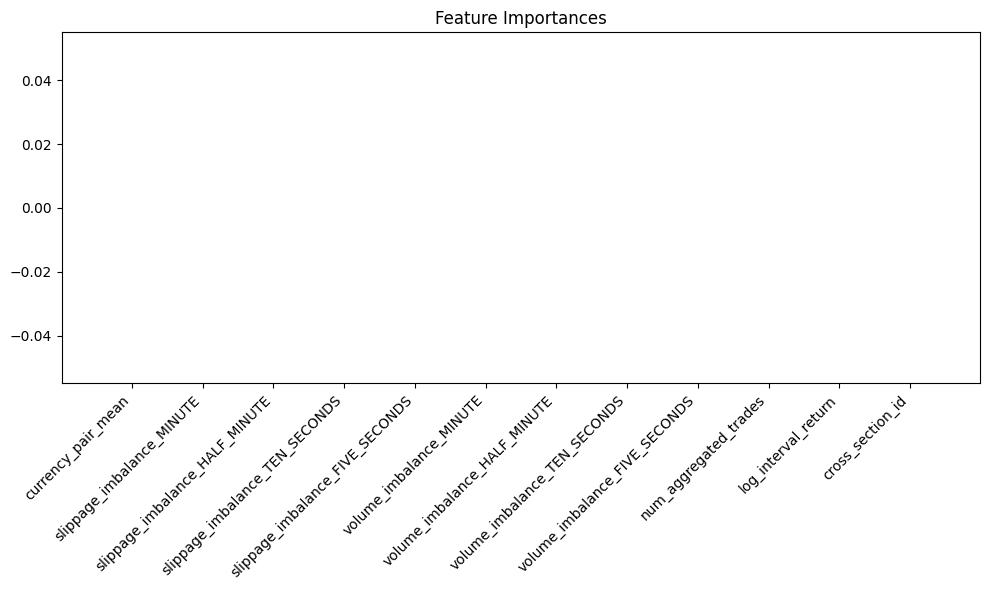

In [20]:
plot_feature_importance(rf_model, X_train.columns)